# SI 618 Homework 6: Clustering

## The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, puctuation, etc. of written sentences.
- 10 pt: Code is written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

## Top-level Goal
Your overall goal in this assignment is to cluster airplane incidents according to the text contained in the summaries of the incidents.  This will provide an opportunity for you to apply the methods we talked about in the lecture. 

You should pick a decade (i.e. any contiguous 10-year span) of air crashes data, focus on the column called "summary" and try to cluster the air crashes based on these summaries using both hierarchical and k-means clustering.

Hint:
- Be careful with the choice of decade, some decades do not have sufficient data to play with.
- pandas.to_datetime is a useful function for transforming string-based dates to datetime objects in a dataframe.
- It's necessary to clean the data before you formally begin to answer the questions.

# Q1 (5 points) Download and describe the data
You can download the air crash dataset through this [page](https://opendata.socrata.com/Government/Airplane-Crashes-and-Fatalities-Since-1908/q2te-8cvq). Download the .csv file (Airplane_Crashes_and_Fatalities_Since_1908.csv) and explore the dataset in the same way as you explored the Pokemon dataset in this week's class.  You should use graphical and analytic methods to describe the data as completely as possible.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.cluster import KMeans # install with name scikit-learn
%matplotlib inline
import re

In [2]:
data = pd.read_csv("Airplane_Crashes_and_Fatalities_Since_1908.csv")
data.Date = pd.to_datetime(data.Date)
data.head(10)

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,1908-09-17,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0,"During a demonstration flight, a U.S. Army fly..."
1,1912-07-12,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0,First U.S. dirigible Akron exploded just offsh...
2,1913-08-06,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0,The first fatal airplane accident in Canada oc...
3,1913-09-09,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0,The airship flew into a thunderstorm and encou...
4,1913-10-17,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0,Hydrogen gas which was being vented was sucked...
5,1915-03-05,01:00,"Tienen, Belgium",Military - German Navy,NaN,NaN,Zeppelin L-8 (airship),NaN,NaN,41.0,21.0,0,Crashed into trees while attempting to land af...
6,1915-09-03,15:20,"Off Cuxhaven, Germany",Military - German Navy,NaN,NaN,Zeppelin L-10 (airship),NaN,NaN,19.0,19.0,0,"Exploded and burned near Neuwerk Island, when..."
7,1916-07-28,NaN,"Near Jambol, Bulgeria",Military - German Army,NaN,NaN,Schutte-Lanz S-L-10 (airship),NaN,NaN,20.0,20.0,0,"Crashed near the Black Sea, cause unknown."
8,1916-09-24,01:00,"Billericay, England",Military - German Navy,NaN,NaN,Zeppelin L-32 (airship),NaN,NaN,22.0,22.0,0,Shot down by British aircraft crashing in flames.
9,1916-10-01,23:45,"Potters Bar, England",Military - German Navy,NaN,NaN,Zeppelin L-31 (airship),NaN,NaN,19.0,19.0,0,Shot down in flames by the British 39th Home D...


In [3]:
# data.Ground = pd.to_numeric(data.Ground) does not work!
# string "2,750" in Ground
print(data.loc[data['Ground'] == '2,750'])
for i in data.loc[data['Ground'] == '2,750'].index:
    data.loc[i, 'Ground'] = 2750
data.Ground = pd.to_numeric(data.Ground)

           Date   Time                 Location           Operator Flight #  \
4803 2001-09-11  08:47  New York City, New York  American Airlines       11   
4804 2001-09-11  09:03  New York City, New York   United Air Lines      175   

                     Route              Type Registration      cn/In  Aboard  \
4803  Boston - Los Angeles  Boeing 767-223ER       N334AA  22332/169    92.0   
4804  Boston - Los Angeles  Boeing B-767-222       N612UA   21873/41    65.0   

      Fatalities Ground                                            Summary  
4803        92.0  2,750  The aircraft was hijacked shortly after it lef...  
4804        65.0  2,750  The aircraft was hijacked shortly after it lef...  


In [8]:
print(data.shape)
print(data.dtypes)
print(data.describe())
data_wo911 = data.loc[data['Ground'] != 2750]

(5268, 13)
Date            datetime64[ns]
Time                    object
Location                object
Operator                object
Flight #                object
Route                   object
Type                    object
Registration            object
cn/In                   object
Aboard                 float64
Fatalities             float64
Ground                 float64
Summary                 object
dtype: object
            Aboard   Fatalities       Ground
count  5246.000000  5256.000000  5246.000000
mean     27.554518    20.068303     1.608845
std      43.076711    33.199952    53.987827
min       0.000000     0.000000     0.000000
25%       5.000000     3.000000     0.000000
50%      13.000000     9.000000     0.000000
75%      30.000000    23.000000     0.000000
max     644.000000   583.000000  2750.000000


In [9]:
print(data.isna().sum())

Date               0
Time            2219
Location          20
Operator          18
Flight #        4199
Route           1706
Type              27
Registration     335
cn/In           1228
Aboard            22
Fatalities        12
Ground            22
Summary          390
dtype: int64


Text(0.5, 1.0, 'Ground for accidents wo911 ')

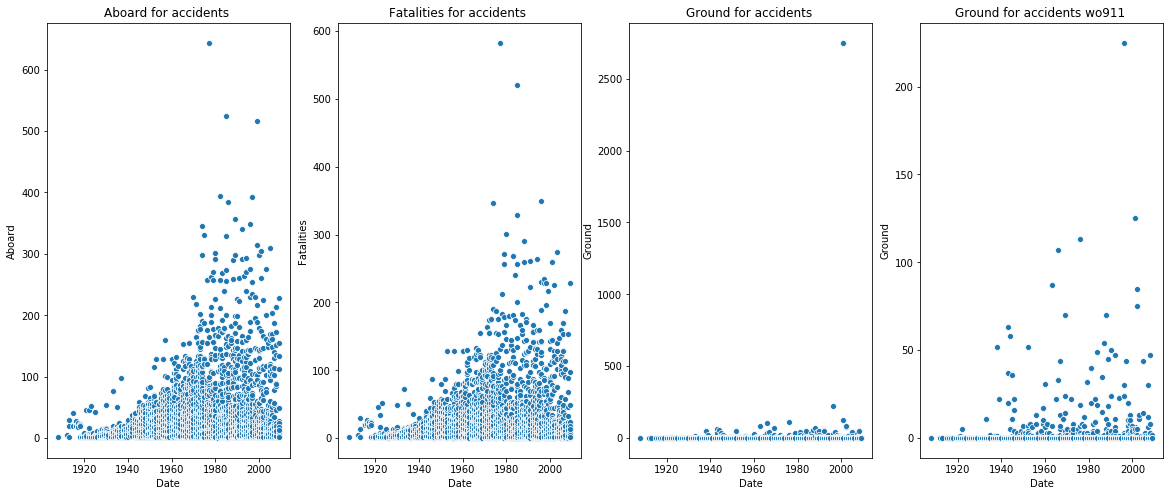

In [11]:
fig, axes = plt.subplots(1,4)
fig.set_size_inches((20,8))    
sns.scatterplot(data["Date"].dt.year,data["Aboard"], ax = axes[0]).set_title("Aboard for accidents ")
sns.scatterplot(data["Date"].dt.year,data["Fatalities"], ax = axes[1]).set_title("Fatalities for accidents ")
sns.scatterplot(data["Date"].dt.year,data["Ground"], ax = axes[2]).set_title("Ground for accidents ")
sns.scatterplot(data_wo911["Date"].dt.year,data_wo911["Ground"], ax = axes[3]).set_title("Ground for accidents wo911 ")

From above summarys, probability as time came to 2000, people Abroad, Fatilities and Ground in accidenst all increased. Fortunately, there is still some probability to survive during accidents, as the mean of Abroad is 13 while the mean of Fatalities is 9. Except for 911 accident (2750), in most cases, people passed away by airplane accidents range from 0 around 250.

# Q2 (10 pts): Create a roadmap to process the data
Think of how you will solve the problems in different steps.  What kind of data you need to prepare for clustering? How would you run clustering algorithms on the dataset?  Please write down your thoughts below and specify your expectations of the clustering results.

a) Transfer text by clearning stop words, lower case, etc, and then save clearned text into a column of dataframe.

b) plot the hierarchical plot, although if the x of plot have too much information, it might be not helpful.

c) visulizing classification after 2 main PCAs. Kmean algorithm and different ways can be used for to choose k, ploting criteria value along with changes of k.

# Q3 (20 pts): Text processing
With each summary, we want to transform the text into a frequency vector. For example, if we have two summaries:
- "The plane was crashed with no alarms. Checking the plane."
- "The plane was crashed on a mountain. "

After some basic text processing such as lowercases and removing stop words, you can create a frequency dataframe like this:

![Frequency Table](freq_table.png)

Please transpose the dataframe (pandas.DataFrame.transpose) and represent each summary as a frequency vector:

![Freq Table T](freq_table_t.png)

We will calculate the similarity between the summaries and run clustering algorithms based on this frequency tables.

In [133]:
# clean the text
data_wona = data.dropna(subset=["Summary"])

def text_clean(text):
        # lower case
        text = text.lower()
        # replace special char 
        text = re.sub(r'[^\w\s]', " ", str(text)) 
        # remove numbers
        text = re.sub(r'[0-9]+', " ", text)
        # stop words
        string = ""
        for word in text.split():
            if word not in STOP_WORDS:
                string += word + " "
        text = string
        return (text)

data_wona[["Summary"]] = data_wona.Summary.apply(text_clean)
data_wona.head()

/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda2/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,1908-09-17,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,demonstration flight u s army flyer flown orvi...
1,1912-07-12,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,u s dirigible akron exploded offshore altitude...
2,1913-08-06,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,fatal airplane accident canada occurred americ...
3,1913-09-09,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,airship flew thunderstorm encountered severe d...
4,1913-10-17,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,hydrogen gas vented sucked forward engine igni...


In [134]:
# summary uniqye words in all text
total_text = [words.split() for words in data_wona.Summary]
from itertools import chain
total_text_unique = list(set(chain.from_iterable(total_text)))
len(total_text_unique)

8787

In [185]:
# define the word count
from collections import Counter, defaultdict

def freq_count(strings):
    for index, row in strings:
        for word in row.split():
            dictionary[word] +=1
    return (dictionary)

In [192]:
# new method, probability, a little slow
frequency = pd.DataFrame(index = total_text_unique)
frequency.head()

for i in range(len(data_wona)):
    word_count = Counter(data_wona.iloc[i].Summary.split())
    for word in word_count:
        frequency.loc[word, i] = word_count[word]

In [193]:
frequency.head()

,0,1,2,3,4,5,6,7,8,9,...,4868,4869,4870,4871,4872,4873,4874,4875,4876,4877
itek,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cote,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
panel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stray,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
frequency2 = frequency.copy()
frequency2 = frequency2.T
frequency2.head()

,itek,clip,cote,panel,stray,berlin,neared,helilcopter,alpha,gablenz,...,gardanibagh,proficiency,quick,iliamna,sopena,birmingham,radar,neuwerk,counteract,guadalajara
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
data_wfrq = data_wona.merge(frequency2, left_index=True, right_index=True)
data_wfrq.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,...,gardanibagh,proficiency,quick,iliamna,sopena,birmingham,radar,neuwerk,counteract,guadalajara
0,1908-09-17,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1912-07-12,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1913-08-06,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1913-09-09,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1913-10-17,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Q4 (20 pts): Clustering
- Please run both the hierarchical clustering and k-means algorithms on the created dataframe.
- What do the results look like? Drawing the hierarachical clustering dendrogram may be helpful (or it might not -- how would you simplify an overly dense dendrogram?).
- How did you choose the number of clusters? For k-means clustering, please use the four methods mentioned in our lecture to choose an appropriate number of clusters.

In [202]:
frequency2 = frequency2.fillna(0)

In [203]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [204]:
model = AgglomerativeClustering(n_clusters=10)
model = model.fit(frequency2)
frequency2['cluster'] = model.labels_

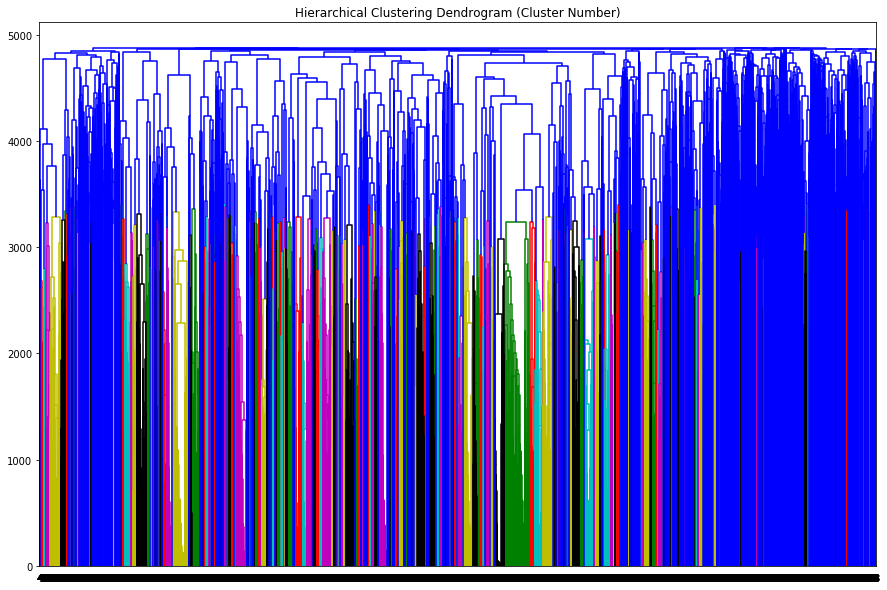

In [207]:
plt.figure(figsize=(15,10))
plt.title('Hierarchical Clustering Dendrogram (Cluster Number)')
plot_dendrogram(model,labels=model.labels_)
plt.xticks(rotation=0,fontsize = 10)
plt.savefig('accidents_new.pdf',format='pdf')
plt.show()

In [209]:
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

pca = PCA(n_components=2).fit(frequency2)
data2d = pca.transform(frequency2)

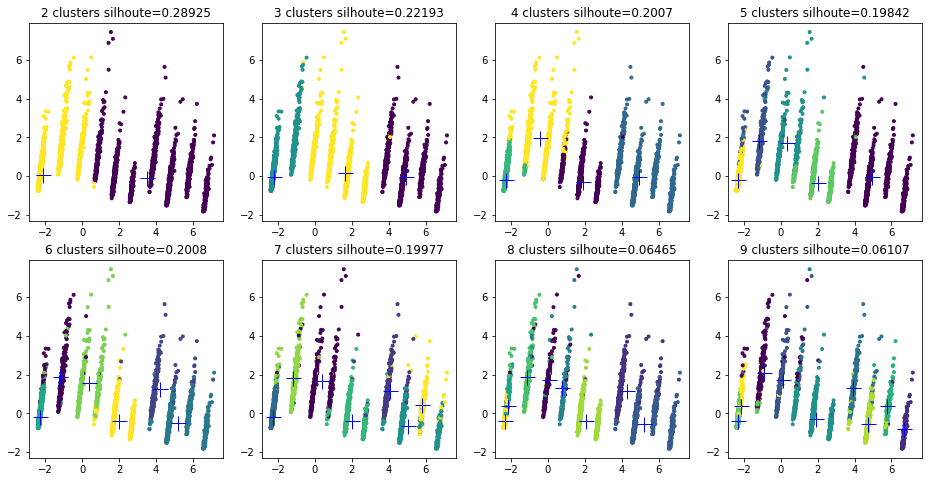

In [211]:
plt.figure(figsize=(16, 8))
scores, n_clusters, preds = [], [], []
for i in range(2, 10):
    kmean = KMeans(n_clusters = i).fit(frequency2)
    scores.append(kmean.score(frequency2))
    n_clusters.append(i)
    pred = kmean.predict(frequency2)
    preds.append(pred)
    plt.subplot(2, 4, i - 1)
    plt.title(f"{i} clusters silhoute={np.round(silhouette_score(frequency2, pred), decimals=5)}")
    plt.scatter(data2d[:, 0], data2d[:, 1], c=pred, marker = '.')
    
    centroids = kmean.cluster_centers_
    centroids2d = pca.transform(centroids)
    plt.plot(centroids2d[:, 0], centroids2d[:, 1], 'b+', markersize=15)


In [212]:
# rule of thumb
np.sqrt(len(frequency2)/2)

49.38623289946298

(1, 15.65)

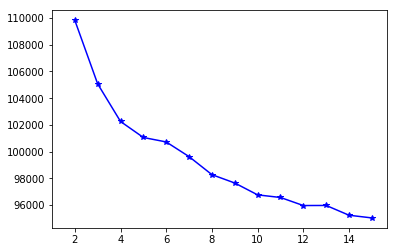

In [215]:
from sklearn import metrics

# elbow plot
cost = []
for k in range(2,16):
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=10)
    k_means.fit(frequency2)
    cost.append(k_means.inertia_)

fig, ax = plt.subplots()
plt.plot(range(2,16), cost, 'b*-')
plt.xlim(1, plt.xlim()[1])

(1, 15.65)

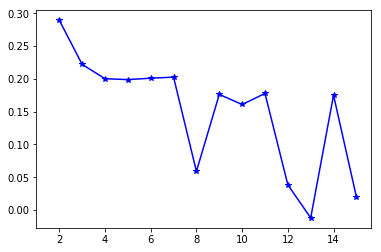

In [216]:
# silhouette plot
cost = []
for k in range(2,16):
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=10)
    k_means.fit(frequency2)
    cost.append(metrics.silhouette_score(frequency2, k_means.labels_))

# kIdx = np.argmax(cost)
fig, ax = plt.subplots()
plt.plot(range(2,16), cost, 'b*-')
plt.xlim(1, plt.xlim()[1])

From the first plot of k between 2 and 10, 2 or 3 might be a good choice. From the rule of thumb, k should be 49. We can see from elbow plot, there is no obvious stable turning point, meaning after some k, the value of y would become quite stable. From the Silhouette Method, the better value in y suggests a better choice of K. Therefore, the plot indicates K= 1-6 might be better than others. In summary, 3 might be a good choice.

# Q5 (20 pts): Explain your clustering results
- How can you explain your clustering results? What kind of summaries are included in each cluster?
- Could you select some representative examples for each cluster?
- Word cloud, which has been used in the last assignment, may be helpful for understanding the clustering results

In [217]:
# according to above plots, we choose k = 3
frequency3 = frequency2.copy()
kmean = KMeans(n_clusters = 3).fit(frequency3)
predlabel = kmean.predict(frequency3)
frequency3.cluster = predlabel

In [218]:
class_0_words = dict(frequency3[frequency3.cluster==0].sum())
class_1_words = dict(frequency3[frequency3.cluster==1].sum())
class_2_words = dict(frequency3[frequency3.cluster==2].sum())

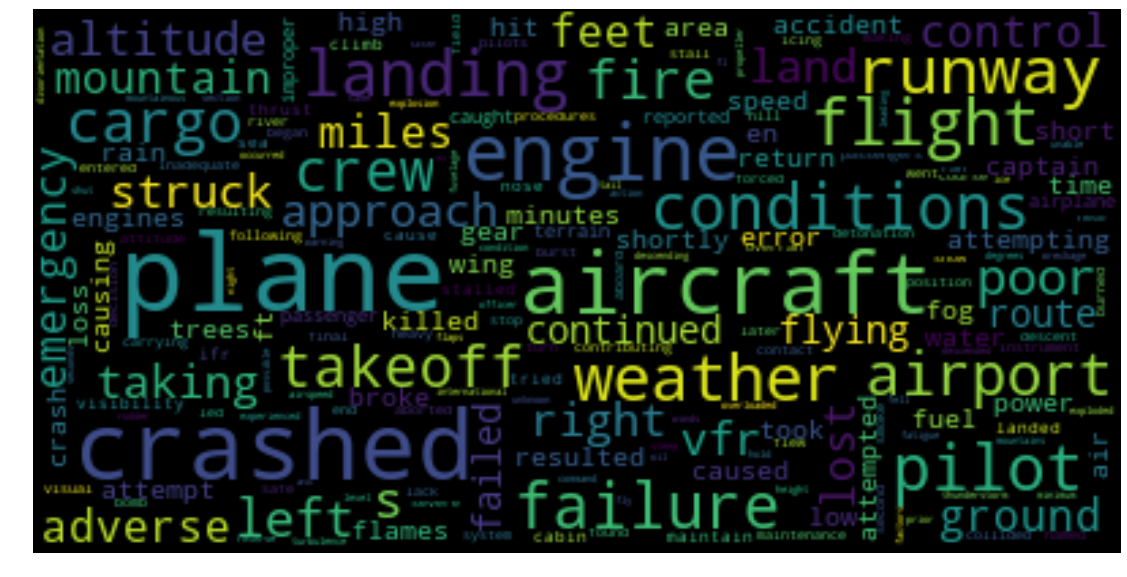

In [221]:
# word cloud 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate_from_frequencies(class_0_words)
plt.figure(figsize=(45,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

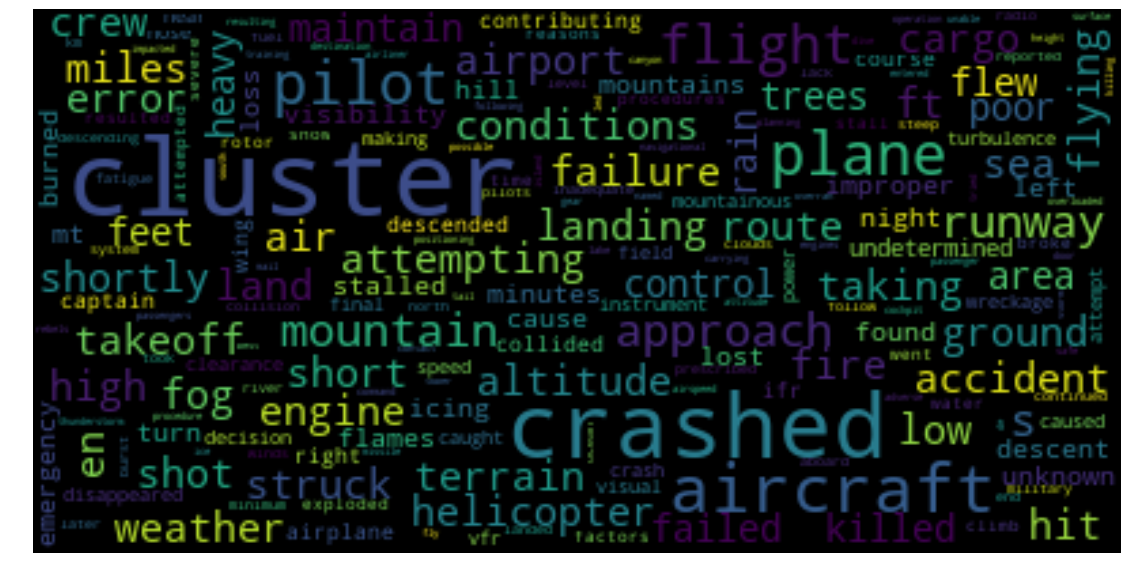

In [222]:
wordcloud = WordCloud(max_font_size=40).generate_from_frequencies(class_1_words)
plt.figure(figsize=(45,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

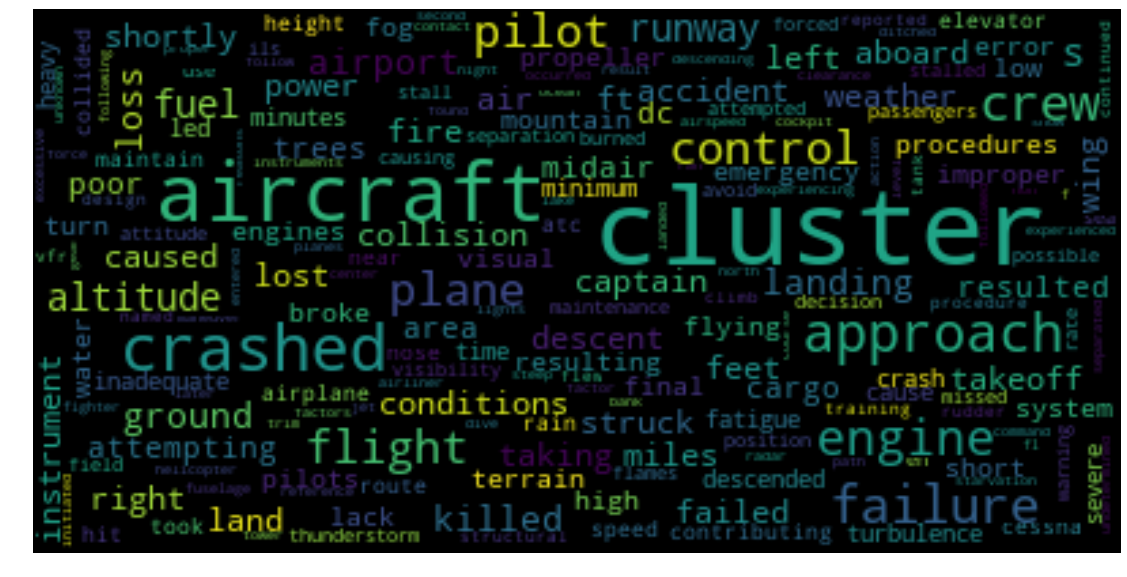

In [223]:
wordcloud = WordCloud(max_font_size=40).generate_from_frequencies(class_2_words)
plt.figure(figsize=(45,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

From first cluster, airport, fire, pilot, and crashed might be clustered togher. From second cluster, landing, mountain, plane, and crashed might be clustered togher. From third cluster, approach, failure, collision, and crashed might be clustered togher. These wordcloud provide some useful inofmrtaion about how the accidetns happens and related situation they might face.

# Q5 (5 pts): Reflect on your thoughts
When you completes the clustering, please look back to your original plan for the clustering. 
- Within your plan, which steps are actually taken eventually? Which are not?  What modifications did you make to your planned process?
- Are the clustering results different from your expectations? Did you find anything unexpected or surprising?

In text processing procedure and count frequency for each summary, it costs lots of time to add the word frequency vectors to the air crush. To improve this process more efficiently, I might try to create dictionary for each summary text, and then only need to loop each row to figure out the freq for all summaries.
The clustering results is rasonable. And from the wordcloud, it is good to know some useful inforamtion. 